# The inverse power method

For more detail about the method in general, see: https://en.wikipedia.org/wiki/Inverse_iteration

Here we'll keep it simple. The inverse power method is an **iteratitive** procedure to approximate the wave-function. Consider an initial **guess** for the wave-function as $\psi_0$. If we iterate this wave-function to get sucessive approximations $\psi_1$, $\psi_2$, ... eventually we approximate the ground state. The iteration reads as

$$\psi_{k+1} = H^{-1}\psi_k$$

where we assume that at each iteration $\psi_{k+1}$ is renormalized. 

Notice that in this form, the iteration depends on the **inverse** of $H$, which is **not good**!

> We don't like inverses!

But this form help us understand why the iteration works.

Write $\psi_0$ as a sum over the eigenstates $H \phi_n = E_n \phi_n$ and let's iterate a couple of times

$$\psi_0 = \sum_n c_n \phi_n$$

$$\psi_1 = H^{-1} \psi_0 = \sum_n \dfrac{c_n}{E_n} \phi_n$$

$$\psi_2 = H^{-1} \psi_1 = \sum_n \dfrac{c_n}{E_n^2} \phi_n$$

$$\psi_{k+1} = H^{-1} \psi_k = \sum_n \dfrac{c_n}{E_n^{k+1}} \phi_n$$

$$ \cdots $$

$$\psi_{\infty} \approx \dfrac{c_0}{E_0^\infty} \phi_0$$

So, components with large $E_n$ vanish, and the iteration converges to the lowest energy mode. Notice that above we didn't renormalize $\psi_k$ for simplicity.

## Avoid the inverse

Use insted this form below, and solve as a linear system A.x=b.

$$H \psi_{k+1} = \psi_k$$

## Efficiency

Instead of writting $H$ in a matrix representation, let's write it as an **linear operator**, which is essentially a function that receives $\psi$ and returns $H \psi$.

See **scipy's sparse algebra documentation:** 

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.bicg.html


## Gram-Schmidt orthogonalization

Wikipedia is quite clear on it: https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Gram%E2%80%93Schmidt_process.svg/350px-Gram%E2%80%93Schmidt_process.svg.png" width=400/>

**The projector is**

$${\rm proj}_u(v) = \dfrac{\langle u | v \rangle}{\langle u | u \rangle}u$$

And the process follow as

$$u_1 = v_1$$

$$u_2 = v_2 - {\rm proj}_{u_1}(v_2)$$

$$u_3 = v_3 - {\rm proj}_{u_1}(v_3) - {\rm proj}_{u_2}(v_3) $$

$$u_k = v_k - \sum_{j=1}^{k-1} {\rm proj}_{u_j}(v_k)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import scipy.sparse.linalg as sla

In [2]:
L = 10
N = 21
x = np.linspace(-L/2, L/2, N)
dx = x[1]-x[0]

V = 0.5*x**2
# second derivative kernel
kernel = np.array([1, -2, 1])/dx**2

# define a function that takes psi and returns H.psi
def Hpsi(psi):
    # use convolutions for derivatives
    Tpsi = -0.5*np.convolve(psi, kernel, mode='same')
    # the action of V is trivial
    Vpsi = V*psi
    # return all
    return Tpsi + Vpsi

# cast the function above as a scipy LinearOperator
H = sla.LinearOperator([N,N], matvec=Hpsi, rmatvec=Hpsi)

# projector for the Gram-Schmidt orthogonalization
def projUV(u, v):
    uv = np.vdot(u, v)
    uu = np.vdot(u, u)
    return (uv/uu)*u

# implementation of the inverse power method
def invpowermethod(psi, nits, orthos=[]):
    # loop over nits iterations
    for i in range(nits):
        # solve the linear system H.psi(k+1) = psi(k)
        # neglect the info output
        psi, info = sla.bicg(H, psi)

        # Gram-Schmidt orthogonalization
        for ortho in orthos:
            # remove the projected parts from psi
            psi = psi - projUV(ortho, psi)

        # renormalize
        psi = psi/np.linalg.norm(psi)
    
    # done!
    return psi

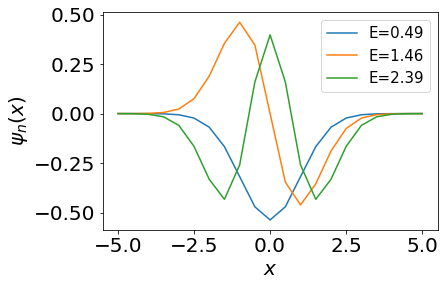

In [3]:
nits = 10 # number of iterations

# initial state = random, contains ~ all eigenstates
psi0 = np.random.randn(N)
# run the inverse power method to get the ground state
psi0 = invpowermethod(psi0, nits)

# next initial psi is the previous times x: odd / even
# add list of previous psis for orthogonalization
psi1 = invpowermethod(x * psi0, nits, orthos=[psi0])
psi2 = invpowermethod(x * psi1, nits, orthos=[psi0, psi1])

# calculate the energies as <psi|H|psi>
e0 = np.vdot(psi0, H(psi0))
e1 = np.vdot(psi1, H(psi1))
e2 = np.vdot(psi2, H(psi2))

# plot the results
plt.plot(x, psi0, label='E='+ str(np.round(e0, 2)))
plt.plot(x, psi1, label='E='+ str(np.round(e1, 2)))
plt.plot(x, psi2, label='E='+ str(np.round(e2, 2)))
plt.legend(fontsize=15)
plt.xlabel(r'$x$')
plt.ylabel(r'$\psi_n(x)$')
plt.show()